# CHEOPS Limb darkening helper

One approach for fitting limb darkening as part of an exoplanet transit fit is to use some fitting from the outputs of stellar atmosphere models. Examples being [Ian Howarth's SPAM approach](http://adsabs.harvard.edu/abs/2011MNRAS.418.1165H) and [Hannu Parviainen's LDTk](http://adsabs.harvard.edu/abs/2015MNRAS.453.3821P).

If we want to use these approaches, then this would involve having a large grid of stellar atmosphere models ready to use for each fit, which would consist of a significant amount of disk space, and computational overhead for each fit whilst the model atmosphere outputs are convolved with the filters required for that fit.

Since this work has a tight focus on transit lightcurves from the [CHEOPS](http://cheops.unibe.ch/) mission, we can make a much smaller grid that contains just the information required for determining limb darkening for CHEOPS lightcurves.

This notebook describes how to create that table

### Getting started

Import the required packages

In [1]:
% pylab inline
import numpy as np

import glob

from scipy.interpolate import interp1d
from scipy.integrate import simps

from astropy.io import fits
from astropy.utils.console import ProgressBar

import pandas as pd

import matplotlib.pylab as plt
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


### The model atmospheres

The grid of atmosphere models used was the [Husser et al 2013](http://adsabs.harvard.edu/abs/2013A%26A...553A...6H) grid of PHOENIX models, which was accessed from [phoenix.astro.physik.uni-goettingen.de](http://phoenix.astro.physik.uni-goettingen.de/) on 28th March 2017. The required data are stored in the spec_int files, which for each model atmosphere contain a spectral intensity value for a range of (~80) angles of $\mu$ for every 0.1 nm in the range 50 - 2600 nm.

To produce the intensity values for each model atmosphere and limb angle, the spectral intensity information from the model atmosphere must be convolved with the spectral response curve of the CHEOPS filter, and that is then integrated over wavelength.

The key steps required are:
- Build a function for one stellar atmosphere model
    - to convolve with the bandpass
    - integrate over wavelength
    - for each given mu angle
    - correct for radius definition
- Loop through all of the atmosphere models
- Export to file

In [2]:
def read_PHOENIX(chosen_path):
    with fits.open(chosen_path) as f:
        I = (f[0].data)/100.           # matrix of spectral intensity values, scaled down for easier calculations
        mu = f['MU'].data              # mu values spectral intensity is calculated for in this model
        CRVAL1 = f[0].header['CRVAL1'] # wavelength start value (in Angstrom)
        CDELT1 = f[0].header['CDELT1'] # wavelength step size (in Angstrom)
        teff = f[0].header['PHXTEFF']  # effective temperature of model (K)
        logg = f[0].header['PHXLOGG']  # log g of model
        feh = f[0].header['PHXM_H']    # metallicity of model
    wavelengths = (np.arange(I.shape[1]) * CDELT1 + CRVAL1)/10. # convert to nm to match response functions
    return wavelengths, I, mu, teff, logg, feh

We can now locate all the atmosphere models, with the list of paths stored in: `model_list`

**Note:** this will only work if the models are stored in the same location on the computer this is running on

In [3]:
model_list = []
model_list.extend(glob.glob('../phoenix2011/Z-0.0/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-0.5/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-1.0/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-1.5/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-2.0/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-3.0/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z-4.0/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z+0.5/*.fits'))
model_list.extend(glob.glob('../phoenix2011/Z+1.0/*.fits'))
print("Number of models found: ",len(model_list))

Number of models found:  7260


### The bandpass

We can now load the *CHEOPS* bandpass into memory.

Since the calculated wavelengths in each model atmosphere output file are the same, we can save some time by interpolating the bandpass to match the PHOENIX model output for the convolution and integration step. The interpolated bandpass is then stored in `filt_int`.

In [4]:
filt = np.loadtxt('./ld_data/cheops.txt')

init_wavelengths, _I, _mu, _teff, _logg, _feh = read_PHOENIX(model_list[409])
filt_int = np.interp(init_wavelengths,filt[:,0],filt[:,1])

### Example spectrum

To demonstrate the process involved in producing the grid, here are a couple of example plots.

Below is a plot of the model atmosphere output at 2 different limb angles (shown in red), plotted with the *CHEOPS* spectral response (shown in orange), and the result of the convolution of the two for each limb angle (shown in blue).

Example model: ../phoenix2011/Z-0.0/lte05500-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
Effective temperature: 5500.0 K, log g: 4.5 , [Fe/H]: 0.0


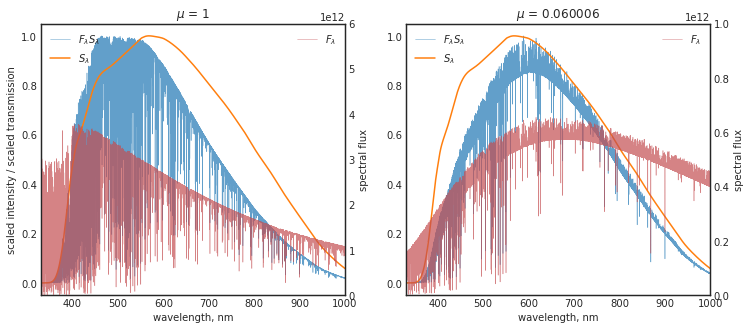

In [5]:
_filt_spec = (_I * filt_int).T
print('Example model:',model_list[409])
print('Effective temperature:',_teff,'K, log g:',_logg,', [Fe/H]:',_feh)

j = 40
cp = sb.color_palette('deep')
with sb.axes_style('white'):
    fig,axs = plt.subplots(1,2,figsize=(12,5))
    axs2 = axs[0].twinx()
    
    axs[0].plot(init_wavelengths,_filt_spec[:,-1]/np.max(_filt_spec[:,-1]),lw=0.5,alpha=0.7,label=r'$F_{\lambda} S_{\lambda}$')
    axs2.plot(init_wavelengths,_I[-1,:],lw=0.5,c=cp[2],alpha=0.7,label=r'$F_{\lambda}$')
    axs[0].plot(init_wavelengths,filt_int/np.max(filt_int),label=r'$S_{\lambda}$')
    axs[0].legend(loc=2)
    axs2.legend(loc=1)
    
    axs4 = axs[1].twinx()
    
    axs[1].plot(init_wavelengths,_filt_spec[:,j]/np.max(_filt_spec[:,j]),lw=0.5,alpha=0.7,label=r'$F_{\lambda} S_{\lambda}$')
    axs4.plot(init_wavelengths,_I[j,:],lw=0.5,c=cp[2],alpha=0.7,label=r'$F_{\lambda}$')
    axs[1].plot(init_wavelengths,filt_int/np.max(filt_int),label=r'$S_{\lambda}$')
    axs[1].legend(loc=2)
    axs4.legend(loc=1)
    
    plt.setp(axs[0],title=r'$\mu$ = 1')
    plt.setp(axs[1],title=r'$\mu$ = '+str(_mu[j]))
    plt.setp(axs[0],xlim=[330,1000])
    plt.setp(axs[1],xlim=[330,1000])
    plt.setp(axs[0],xlabel=r'wavelength, nm',ylabel=r'scaled intensity / scaled transmission')
    plt.setp(axs2,ylabel=r'spectral flux')
    plt.setp(axs2,ylim=[0,6e12])
    plt.setp(axs[1],xlabel=r'wavelength, nm')
    plt.setp(axs4,ylabel=r'spectral flux')
    plt.setp(axs4,ylim=[0,1e12])

For that same model atmosphere, here is the limb profile as a result of intergrating the above convolutions with respect to wavelength for each limb angle.

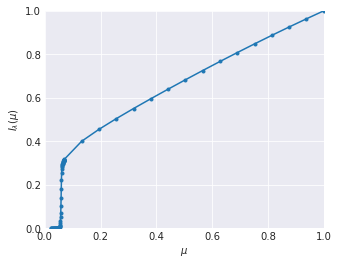

In [6]:
_flux = []
for j in range(_mu.shape[0]):
    _flux.append(simps(_filt_spec[:,j],init_wavelengths))

_flux = _flux/(_flux[-1])
_flux = np.array(_flux)
    
with sb.axes_style('darkgrid'):
    fig,axs = plt.subplots(1,1,figsize=(5,4))
    axs.plot(_mu,_flux,marker='.')
    plt.setp(axs,xlabel=r'$\mu$')
    plt.setp(axs,ylabel=r'$I_{\lambda}(\mu)$')
    plt.setp(axs,xlim=[0,1],ylim=[0,1])

### Stellar radius definition

As can be seen from the plot above, the stellar radius used to define the values of $\mu$ is not the same as how we would define the edge of a star for an exoplanet transit. In order to correct for this inconsistency, we need to redefine the stellar radius as some value inside where it is currently defined and then recalculate the values for $\mu$.

Following [Espinoza et al 2015](http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E) we redefine the stellar radius as the radius where the maximum gradient in intensity is found, which is defined in the function `new_get_rmax`.

An example of this correction for the same model atmosphere as before is shown below.

In [7]:
def new_get_rmax(mu,I0):
    # convert mu to r
    r = np.sqrt(1.-(mu**2.))
    
    # find the maximum derivative point
    i = np.argmax(abs(np.diff(I0)/np.diff(r)))
    
    # make radius correction to values inside new radius
    r_new  = r[i:]/r[i]
    mu_new = np.sqrt(1-r_new**2)
    
    ip_new = I0[i:]
    return r_new, mu_new, ip_new, r[i], mu[i]

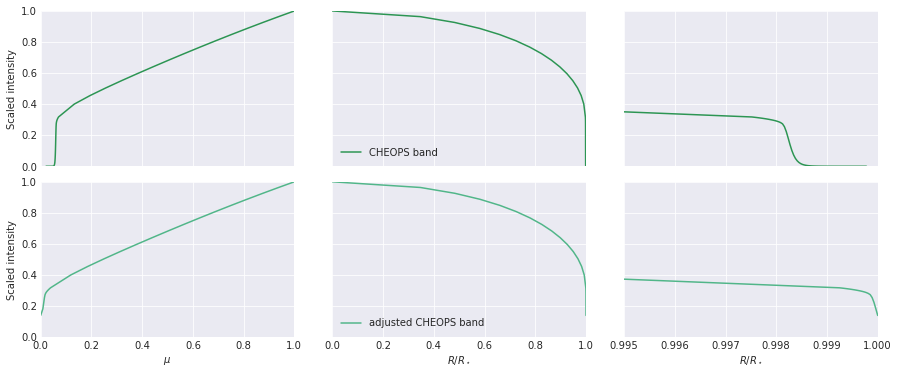

In [8]:
_r = np.sqrt(1.-(_mu**2.))
# Apply corrections
new_r, new_mu, new_I0, _, _ = new_get_rmax(_mu,_flux) # Kepler band

# Plotting correction
gp = sb.color_palette("BuGn_r")

with sb.axes_style('darkgrid'):
    fig,axs = plt.subplots(2,3,figsize=(15,6),sharey='row',sharex='col')
    
    axs[0,0].plot(_mu,_flux,label=r'CHEOPS band',c=gp[1])
    plt.setp(axs[0,0],xlim=[0,1])
    plt.setp(axs[0,0],ylim=[0,1])
    plt.setp(axs[0,0],ylabel=r'Scaled intensity')
    
    axs[0,1].plot(_r,_flux,label=r'CHEOPS band',c=gp[1])
    plt.setp(axs[0,1],xlim=[0,1])
    plt.setp(axs[0,1],ylim=[0,1])
    axs[0,1].legend()

    axs[1,0].plot(new_mu,new_I0,label=r'adjusted CHEOPS band',c=gp[2])
    plt.setp(axs[1,0],xlim=[0,1])
    plt.setp(axs[1,0],ylim=[0,1])
    plt.setp(axs[1,0],xlabel=r'$\mu$')
    plt.setp(axs[1,0],ylabel=r'Scaled intensity')
    
    axs[1,1].plot(new_r,new_I0,label=r'adjusted CHEOPS band',c=gp[2])
    plt.setp(axs[1,1],xlim=[0,1])
    plt.setp(axs[1,1],ylim=[0,1])
    plt.setp(axs[1,1],xlabel=r'$R / R_\star$')
    axs[1,1].legend()

    axs[0,2].plot(_r,_flux,label=r'CHEOPS band',c=gp[1])
    plt.setp(axs[0,2],xlim=[0.995,1])
    plt.setp(axs[0,2],ylim=[0,1])
    
    axs[1,2].plot(new_r,new_I0,label=r'adjusted CHEOPS band',c=gp[2])
    plt.setp(axs[1,2],xlim=[0.995,1])
    plt.setp(axs[1,2],ylim=[0,1])
    plt.setp(axs[1,2],xlabel=r'$R / R_\star$')
    
    plt.subplots_adjust(hspace = 0.1, wspace = 0.15)

### Generating the grid

Now we can produce the grid itself, and save the table to use later.

In [9]:
columns = ['Teff','logg','Z','mu','intensity','mu_fac','r_fac']

grid1 = []
grid2 = []

with ProgressBar(len(model_list), ipython_widget=True) as bar:
    for item in model_list:
        wavelengths, I, mu, teff, logg, feh = read_PHOENIX(item)

        filt_spec = (I * filt_int).T

        flux = []
        for j in range(mu.shape[0]):
            flux.append(simps(filt_spec[:,j],wavelengths))

        flux = flux/(flux[-1])
        flux = np.array(flux)
            
        new_r,new_mu,new_I0,r_fac,mu_fac = new_get_rmax(mu,flux)
            
        even_mus = np.linspace(new_mu.min(),1,200)
        interp_I = interp1d(new_mu,new_I0,kind='quadratic',assume_sorted=True)(even_mus)
            
        for q in range(mu.shape[0]):
            grid1.append([teff,logg,feh,mu[q],flux[q],mu_fac,r_fac])

        for s in range(even_mus.shape[0]):
            grid2.append([teff,logg,feh,even_mus[s],interp_I[s],mu_fac,r_fac])

        bar.update()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [10]:
df = pd.DataFrame(data=grid1,columns=columns)
df2 = pd.DataFrame(data=grid2,columns=columns)

# for same distribution of mu as defined in model
df.to_csv('phoenix_cheops_intensity_table.csv')
# for 200 evenly-spaced mu values (intensities interpolated)
df2.to_csv('phoenix_cheops_intensity_table_resampled.csv')